<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/TEST_Camembert_LM%26TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 204kB 13.3MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 


In [3]:
!pip install -Uq transformers
from fastai.text.all import *

     |████████████████████████████████| 2.3MB 11.3MB/s 
     |████████████████████████████████| 3.3MB 39.2MB/s 
     |████████████████████████████████| 901kB 46.4MB/s 


In [4]:
!pip install nbdev

     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 


In [5]:
# # better display of review text in dataframes
# pd.set_option('display.max_colwidth', None) 

# CamentBERT

In [6]:
!pip install sentencepiece

from transformers import CamembertTokenizer, CamembertForCausalLM

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True)
model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True, add_cross_attention=True)

#transformers.RobertaForCausalLM.from_pretrained(pretrained_model_name_or_path='roberta-base', add_cross_attention=True, is_decoder=True, bos_token_id=<bos-id>, eos_token_id=<eos-id>)?

     |████████████████████████████████| 1.2MB 13.5MB/s 


Some weights of CamembertForCausalLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta.encoder.layer.6.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.8.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.10.crossattention.output.dense.weight', 'roberta.encoder.layer.1.crossattention.self.value.bias', 'roberta.encoder.layer.11.crossattention.self.query.bias', 'roberta.encoder.layer.5.crossattention.self.value.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.11.crossattention.self.query.weight', 'roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.10.crossattention.self.query.weight', 'roberta.encoder.layer.4.crossattention.self.value.bias', 'roberta.encoder.layer.2.crossattention.self.query.bias', 'roberta.encoder.layer.4.cro

NOTE: Language Modeling
- **Causal language modeling**: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.
- **Masked language modeling**: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

In [9]:
model.eval()

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

## Testing the tokenizer

In [7]:
tokenizer.vocab_size

32005

In [8]:
ids = tokenizer.encode('Ce texte est affligeant, et')
ids

[5, 148, 930, 30, 5639, 1187, 17059, 7, 14, 6]

In [87]:
# decoding
tokenizer.decode(ids)

'<s> Ce texte est affligeant, et</s>'

# Getting the data

In [10]:
#creating a directory allocine
path = Path('/content/allocine/')
path.mkdir(parents=True, exist_ok=True)

In [11]:
#creating a directory allocine
path = Path('/content/allocine/models')
path.mkdir(parents=True, exist_ok=True)

In [12]:
path = Path('/content/allocine/'); path

Path('/content/allocine')

In [13]:
# downloading the AlloCine dataset
!wget -q https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/raw/master/allocine_dataset/data.tar.bz2
!tar -xf /content/data.tar.bz2 -C '/content/allocine'

In [14]:
train_df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=10000)
train_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


NOTE: polarity: `0` negative review; `1` positive review

In [15]:
val_df = pd.read_json(path/'data/val.jsonl', lines=True, nrows=1000)
val_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [16]:
train_df.to_csv(path/'data/train.csv', encoding = 'utf-8', header = False, index = False)

In [17]:
val_df.to_csv(path/'data/val.csv', encoding = 'utf-8', header = False, index = False)

In [18]:
# training dataset
df_train = pd.read_csv(path/'data/train.csv', encoding = 'utf-8', header=None)
df_train.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0
1,http://www.allocine.fr/film/fichefilm-172430/critiques/spectateurs,"Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la sauce années 2000 : les dandys-punk de Kubrick ont laissé place à des papys lubriques déguisés en sacs-poubelles forniquant les troncs d'arbres, le dispositif esthétique se résume à du filmage-réalité enfilant des scènes de destruction, de soumission, de pornographie ou encore de maltraitance ( youtube, youtube et re-youtube...) et la bande-son se limite à des ricanements malades, des rengaine...",0


In [19]:
# validation dataset
df_valid = pd.read_csv(path/'data/val.csv', encoding = 'utf-8', header=None)
df_valid.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0
1,http://www.allocine.fr/film/fichefilm-272/critiques/spectateurs,"The Wall a été réalisé par Alan Parker (Fame, Midnight Express, Evita) et Roger Waters (bassiste de Pink Floyd). Le film ne contient quasiment aucun dialogue, il s'agit en fait du double album conceptuel The Wall en images. Pink est une rock star déchue qui utilise tous les paradis artificiels possibles pour fuir le réel, mais cela ne fait que l'enfoncer encore plus dans son état sombre. Ce film est tout autant fascinant que dérangeant : on regarde cet homme sombrer dans la paranoïa, sans pouvoir rien faire, comme les spectateurs pervers d'une mise à mort, fascinés par cette chose incontrô...",1


In [20]:
print(train_df['polarity'].unique(), val_df['polarity'].unique())

[0 1] [0 1]


In [21]:
all_texts = np.concatenate([df_train[1].values, df_valid[1].values])

In [22]:
print(len(train_df), len(val_df), len(all_texts))

10000 1000 11000


### Testing the tokenizer on movie review

In [23]:
some_review = train_df.review[0]; some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [24]:
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [25]:
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [26]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

In [27]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [28]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [29]:
# tls.train[0],tls.valid[0]

In [30]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([332]), torch.Size([93]))

In [31]:
show_at(tls.train, 0)

Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme blanche en 8 mouvements(!!)ou laiss

In [32]:
show_at(tls.valid, 0)

Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.


## Dataloader

In [33]:
#bs,sl = 4,256 # not working
bs,sl = 4, 256
dls_lm = tls.dataloaders(bs=bs, seq_len=sl)

In [34]:
dls_lm.tfms

Pipeline: TransformersTokenizer

In [35]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"Magnifique histoire, très touchante. Je ne m'attendais pas à un tel résultat n'y au dénouement que le film allait suivre. Bernard Campan et Isabelle Carré forment un très bon duo, traversant les épreuves. Des récompenses bien méritées!! Pour une histoire qui en dit long. Richard Widmark, Dana Andrews et Gary Merrill réunis dans un film sans la moindre présence féminine, le fait que le corps d'armée évoqué soit méconnu donnent un semblant d'intérêt à cette oeuvre qui rend hommage à ces hommes en uniformes (mais souvent en slip de bain!!!). La Fox a mis la gomme aussi au niveau des moyens mais certainement pas au niveau de la réalisation, sans personnalité et originalité, en mettant un tâcheron derrière la caméra et de l'écriture scénaristique qui donne lieue à aucune intensité et à des personnages qui sont trop peu consistants. Bon alors je finis ou pas sur un jeu de mots","histoire, très touchante. Je ne m'attendais pas à un tel résultat n'y au dénouement que le film allait suivre. Bernard Campan et Isabelle Carré forment un très bon duo, traversant les épreuves. Des récompenses bien méritées!! Pour une histoire qui en dit long. Richard Widmark, Dana Andrews et Gary Merrill réunis dans un film sans la moindre présence féminine, le fait que le corps d'armée évoqué soit méconnu donnent un semblant d'intérêt à cette oeuvre qui rend hommage à ces hommes en uniformes (mais souvent en slip de bain!!!). La Fox a mis la gomme aussi au niveau des moyens mais certainement pas au niveau de la réalisation, sans personnalité et originalité, en mettant un tâcheron derrière la caméra et de l'écriture scénaristique qui donne lieue à aucune intensité et à des personnages qui sont trop peu consistants. Bon alors je finis ou pas sur un jeu de mots pourri"
1,"tériser pour redécouvrir ce chef d'œuvre en hd. Voilà 15 ans déjà que j'ai entendu parler de ce film que je savais réputé, mais ce n'est qu'aujourd'hui (2013) que je le vois pour la 1ere fois. Franchement le jeux du duo d'acteur Bouchez-Régnier est si réaliste que cela en devient confondant, on se croirait presque dans un documentaire... je sais pas si elle ont mis des caractéristiques propres à leur véritables caractères dans les personnages joués...tellement cela sonne juste... ou si tout cela est inventé sur papier et qu'elles ont tatonné et essayé de trouvé comment joué tout cela au mieux... tout cela est un mystère, il faut surement être dans le milieu du cinéma pour comprendre le procésus de construction d'un rôle... Mais enfin bref...je m'égare... Ce film qui sent le mélodrame...on le préssent il est vrai... mérite les récompenses qu'il a reçu... que dire de plus... allez donc","ser pour redécouvrir ce chef d'œuvre en hd. Voilà 15 ans déjà que j'ai entendu parler de ce film que je savais réputé, mais ce n'est qu'aujourd'hui (2013) que je le vois pour la 1ere fois. Franchement le jeux du duo d'acteur Bouchez-Régnier est si réaliste que cela en devient confondant, on se croirait presque dans un documentaire... je sais pas si elle ont mis des caractéristiques propres à leur véritables caractères dans les personnages joués...tellement cela sonne juste... ou si tout cela est inventé sur papier et qu'elles ont tatonné et essayé de trouvé comment joué tout cela au mieux... tout cela est un mystère, il faut surement être dans le milieu du cinéma pour comprendre le procésus de construction d'un rôle... Mais enfin bref...je m'égare... Ce film qui sent le mélodrame...on le préssent il est vrai... mérite les récompenses qu'il a reçu... que dire de plus... allez donc"


## Tokenizing the Allocine Dataset

In [36]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [37]:
len(tokenized)

11000

In [38]:
tokenizer.vocab_size

32005

In [39]:
# adding tokens to the vocab
tokenizer.add_tokens('tokenized')
# resizing the model
model.resize_token_embeddings(len(tokenizer))

Embedding(32006, 768)

In [40]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

## Learner

In [41]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [42]:
# del learn

In [43]:
learn = Learner(dls_lm, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [44]:
learn.model

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32006, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [45]:
learn.validate()

(#2) [14.1454439163208,1390875.375]

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

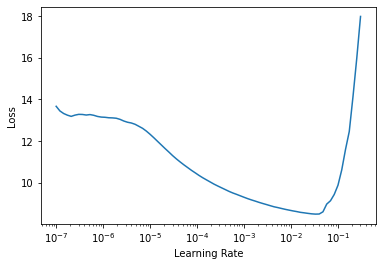

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.102899,3.969334,52.949276,02:02


## Saving the trained model

In [48]:
# saving the newly trained model
learn.save('1epoch')

Path('models/1epoch.pth')

## Saving the model's vocabulary

In [49]:
# saving the vocabulary
vocab= tokenizer.save_vocabulary('/content/allocine/data/')

NOTE: the file name is `sentencepiece.bpe.model`

In [50]:
# other way to save the vocabulary by making a list
vocab_lm = list(tokenizer.get_vocab()) #dictionary

In [51]:
vocab_lm[:10]

['<s>NOTUSED',
 '<pad>',
 '</s>NOTUSED',
 '<unk>',
 '<s>',
 '</s>',
 ',',
 '▁de',
 '.',
 's']

In [83]:
type(vocab_lm)

list

In [52]:
len(vocab_lm)

32005

In [53]:
# vocab size assertion
assert(len(vocab_lm) == tokenizer.vocab_size) # it returns True!

## Inference

In [54]:
df_valid.head(1)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [55]:
#prompt = "ce film est un navet, il met en"
prompt = "c'est une histoire abracadabrantesque"

In [56]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 13])

In [57]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

In [58]:
tokenizer.decode(preds[0].cpu().numpy())

"<s> c'est une histoire abracadabrantesque</s>e par une bande d'acteurs à l'image de l'histoire. Les acteurs sont tous excellents et les scènes d'"

NOTE: The model 'RobertaForCausalLM' is not supported for text-generation. Supported models are ['XLNetLMHeadModel', 'TransfoXLLMHeadModel', 'ReformerModelWithLMHead', 'GPT2LMHeadModel', 'GPTNeoForCausalLM', 'OpenAIGPTLMHeadModel', 'CTRLLMHeadModel', 'TFXLNetLMHeadModel', 'TFTransfoXLLMHeadModel', 'TFGPT2LMHeadModel', 'TFOpenAIGPTLMHeadModel', 'TFCTRLLMHeadModel']

# Text Classification

In [59]:
path

Path('/content/allocine')

In [60]:
df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=30000)
df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


In [61]:
# splitting a df by rows
df_train = df.iloc[10001:-1]; len(df_train)

19998

In [62]:
df_train.to_csv(path/'data/train1.csv', encoding = 'utf-8', header = True, index = False)

In [63]:
df_train.head(1)

,film-url,review,polarity
10001,http://www.allocine.fr/film/fichefilm-50911/critiques/spectateurs,"Quel navet!!!! Un mix entre une réalisation classique et caméra à l'épaule, des acteurs insupportables (voir la rousse dans la voiture donne une irrésistible envie de gifler), un tueur sans charisme..... Légérement gore qui tâche, aucune sensation de stress ne vient nous titiller l'esprit. Slasher basique sans aucun génie, ce film est à oublier voir même à ne pas regarder. Malgré son 1h10, pas possible de le terminer.",0


## Text Dataloader

In [93]:
doc(TextDataLoaders.from_df)

In [67]:
doc(TextBlock.from_df)

In [65]:
print(bs, sl)

4 256


In [66]:
# df_train.columns = ['film-url','review','polarity']  

In [94]:
# Using TextBlock.from_df without vocab
dls_clas = DataBlock(
        blocks=(TextBlock.from_df('review', is_lm=False, vocab=None), CategoryBlock),
        get_y=ColReader('polarity'), 
        get_x=ColReader('text'), # res_col_name should be "text"?
        splitter=RandomSplitter()
).dataloaders(df_train, bs=16, seq_len=512)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [95]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj i 'm a rocket m xxrep 5 a n … xxmaj impossible d'oublier ce tube pour ceux qui aiment xxmaj elton xxmaj john , et si comme moi vous faites carrément partie des fans , alors xxmaj rocketman s'offre à vous comme une incroyable compilation de deux heures . xxmaj disons - le tout de suite : xxmaj taron xxmaj egerton porte le film à lui tout seul . xxmaj il n'a pas vraiment le physique xxunk , ni même le grain de voix ( mais cherche - t - on une copie exacte ? xxmaj non . ) mais pour parvenir à nous faire voir xxmaj elton , xxmaj egerton sort le grand jeu et se donne à 300 % . xxmaj il chante ( souvent merveilleusement ) , et se costume parmi les tenues les plus extravagantes du xxunk ( la xxmaj reine , le démon",1
1,"xxbos xxmaj les xxmaj noces rebelles : xxmaj décidément , xxmaj sam xxmaj mendes a le génie de faire des films et de traité des sujet par comme les autres . xxmaj car encore une fois , on a le doit a un film intense , fort et assez dramatique qui se fini pas comme les autres films : ce qui le rend si particulier et unique . xxmaj car , on a le droit à une histoire d’amour qui montre plus les xxunk et les difficultés qu’on peut rencontrer dans un couple . xxmaj alors que dans d’autres films : ils montrent plus le bonheur et à la fin : tout est bien qui fini bien . xxmaj alors quand dans ce film ( comme dans beaucoup de film de xxmaj sam xxmaj mendes : xxmaj american xxmaj beauty … ) et bien , ce n’est pas la joie",1
2,"xxbos xxmaj bouzi xxmaj bouzouf aime « xxmaj nightmare xxmaj detective » de xxmaj xxunk xxmaj tsukamoto . xxmaj ah ! xxmaj bouzi xxmaj bouzouf se souvient , à la fois avec une larme à l'oeil et un frisson glacial le long de son corps , de ce jour de mars 2001 où il eut affaire pour la première fois à ce xxmaj monsieur xxmaj xxunk . xxmaj le film s'appelait « xxmaj tokyo xxmaj fist » et xxmaj bouzi xxunk tranquillement dans un siège , content de découvrir un réalisateur japonais underground totalement inconnu chez nous ( ce que xxmaj bouzi ne savait pas alors , c'est qu'il était aussi un inconnu au xxmaj japon ) . xxmaj six personnes à peu près allaient assister à la séance . à la fin de la projection , il n'en restait plus que deux , do nt xxmaj bouzi xxmaj bouzouf",1


In [96]:
# Using TextBlock.from_df with vocab
dls_clas = DataBlock(
        blocks=(TextBlock.from_df('review', is_lm=False, vocab=vocab_lm), CategoryBlock),
        get_y=ColReader('polarity'), 
        get_x=ColReader('text'), # res_col_name should be "text"
        
        splitter=RandomSplitter()
).dataloaders(train_df, bs=16, seq_len=512)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [92]:
dls_clas.tfms

(#2) [Pipeline: ColReader -- {'cols': 'text', 'pref': '', 'suff': '', 'label_delim': None} -> Tokenizer -> Numericalize,Pipeline: ColReader -- {'cols': 'polarity', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}]

In [88]:
dls_clas.show_batch(max_n=3)

,text,category
0,"<s>NOTUSED <s>NOTUSED le <s>NOTUSED <s>NOTUSED <s>NOTUSED et <s>NOTUSED <s>NOTUSED est à <s>NOTUSED de la <s>NOTUSED <s>NOTUSED "" <s>NOTUSED and <s>NOTUSED ice <s>NOTUSED <s>NOTUSED "" , <s>NOTUSED 3 <s>NOTUSED en forme <s>NOTUSED aux <s>NOTUSED <s>NOTUSED et à la <s>NOTUSED <s>NOTUSED . <s>NOTUSED ce "" paul "" , <s>NOTUSED avant "" le <s>NOTUSED dernier <s>NOTUSED pub "" , <s>NOTUSED lui aussi sous forme <s>NOTUSED à la <s>NOTUSED <s>NOTUSED . <s>NOTUSED cette fois - ci , <s>NOTUSED la <s>NOTUSED <s>NOTUSED et le <s>NOTUSED américain qui <s>NOTUSED <s>NOTUSED . <s>NOTUSED le <s>NOTUSED est <s>NOTUSED des très <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED et <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED . <s>NOTUSED comme dans <s>NOTUSED de leurs <s>NOTUSED , il faut attendre 10 - <s>NOTUSED que <s>NOTUSED se <s>NOTUSED en place avant que le <s>NOTUSED accélère et que <s>NOTUSED <s>NOTUSED . <s>NOTUSED en gros , attendre <s>NOTUSED de <s>NOTUSED paul , do nt la voix <s>NOTUSED est celle",1
1,"<s>NOTUSED <s>NOTUSED mon dieu , <s>NOTUSED , je crois <s>NOTUSED a <s>NOTUSED été aussi <s>NOTUSED du vide <s>NOTUSED , <s>NOTUSED dire <s>NOTUSED film de <s>NOTUSED bay est vide , <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED de la <s>NOTUSED <s>NOTUSED <s>NOTUSED être de la <s>NOTUSED <s>NOTUSED <s>NOTUSED a vu <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED . <s>NOTUSED je pense que <s>NOTUSED peut sans aucun <s>NOTUSED en faire le <s>NOTUSED maître <s>NOTUSED de la <s>NOTUSED . <s>NOTUSED ce <s>NOTUSED y a de <s>NOTUSED dans ce film <s>NOTUSED <s>NOTUSED <s>NOTUSED a rien , mais rien du tout à <s>NOTUSED . <s>NOTUSED déjà il faut le voir en <s>NOTUSED <s>NOTUSED , la <s>NOTUSED <s>NOTUSED faite par des <s>NOTUSED , ça <s>NOTUSED le coup <s>NOTUSED . <s>NOTUSED il <s>NOTUSED a pas <s>NOTUSED de <s>NOTUSED , et <s>NOTUSED encore moins <s>NOTUSED , genre le <s>NOTUSED <s>NOTUSED qui arrive à <s>NOTUSED dans une église et à qui la <s>NOTUSED",0
2,"<s>NOTUSED <s>NOTUSED tout <s>NOTUSED , je suis devant mon poste de <s>NOTUSED . <s>NOTUSED enfin , je <s>NOTUSED ce <s>NOTUSED ! <s>NOTUSED le film <s>NOTUSED à <s>NOTUSED que <s>NOTUSED déjà <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED parce <s>NOTUSED fait , le film est une grande <s>NOTUSED ! <s>NOTUSED oui , une grande <s>NOTUSED ! <s>NOTUSED tout est <s>NOTUSED <s>NOTUSED , et <s>NOTUSED ça qui est <s>NOTUSED ! <s>NOTUSED et le <s>NOTUSED dans tout cela est que <s>NOTUSED du film ne <s>NOTUSED même pas fait <s>NOTUSED ! <s>NOTUSED en <s>NOTUSED , <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED <s>NOTUSED est un film <s>NOTUSED <s>NOTUSED mais pas <s>NOTUSED du tout . <s>NOTUSED enfin je crois <s>NOTUSED on se pose des <s>NOTUSED en voyant « ça » ! <s>NOTUSED <s>NOTUSED , il y a des <s>NOTUSED <s>NOTUSED . <s>NOTUSED la <s>NOTUSED qui <s>NOTUSED une <s>NOTUSED - forme <s>NOTUSED <s>NOTUSED et <s>NOTUSED surtout le",1


In [ ]:
print(len(dls_clas.train), len(dls_clas.valid))

500 125


In [ ]:
dls_clas.c, dls_clas.vocab

(2,
 (#2) [['<s>NOTUSED', '<pad>', '</s>NOTUSED', '<unk>', '<s>', '</s>', ',', '▁de', '.', 's', "'", '’', '▁la', '▁et', '▁à', '▁le', '▁l', '▁d', '▁les', '▁des', '▁', '▁en', '▁un', '▁pour', '▁du', '-', '▁que', '▁une', '▁dans', '▁est', '▁qui', '▁sur', '▁a', '▁pas', 'e', '▁au', '▁par', '▁(', '▁vous', '▁plus', 'est', '▁avec', '▁:', '▁ce', '▁ne', '▁qu', '▁ou', '▁se', '▁n', '▁je', '▁il', '▁s', ')', '▁Le', 'a', '▁sont', '...', '▁son', 'un', '▁c', '▁La', 'il', '▁nous', '▁«', '▁mais', '▁tout', '▁-', '▁aux', '▁Il', 'une', '▁L', '▁bien', 'ai', '▁Les', '▁votre', '▁j', '▁sa', '▁cette', '▁comme', 'es', 'r', '▁fait', '▁!', '▁C', '▁faire', '▁si', '▁"', 'on', '▁ses', 'en', '▁on', ':', '▁même', '▁»', '▁très', '▁ont', '▁leur', '▁être', '▁aussi', '▁Je', '▁été', '▁y', '▁me', '▁peut', 'y', '▁?', '▁En', 'er', '▁elle', 't', '▁lui', '▁sans', 'nt', '▁A', '▁m', '▁deux', '▁tous', '▁2', '▁ces', ').', '▁J', '/', '▁Pour', '▁1', '▁temps', '▁peu', '▁notre', '▁entre', '▁mon', '"', 'ment', '▁site', 'h', '▁ans', '▁3', '▁

In [ ]:
len(dls_clas.vocab)

2

## Text Learner

In [ ]:
# del learn

In [72]:
from transformers import CamembertModel, CamembertConfig, CamembertForSequenceClassification

In [73]:
configuration = CamembertConfig()

In [74]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base")
# #model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

In [ ]:
# model = CamembertForSequenceClassification.from_pretrained("camembert-base", return_dict=True)
# #model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)

In [ ]:
# # model = CamembertModel(configuration)
# model = CamembertForSequenceClassification(configuration)

In [75]:
configuration = model.config

In [76]:
configuration

CamembertConfig {
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}

In [77]:
configuration.__dict__['architectures'] = 'CamembertForSequenceClassification'

In [78]:
configuration.__dict__['fp16_opt_level'] = "O2"

In [79]:
configuration

CamembertConfig {
  "_name_or_path": "camembert-base",
  "architectures": "CamembertForSequenceClassification",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "eos_token_id": 6,
  "fp16_opt_level": "O2",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}

In [97]:
model

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
tokenizer.vocab_size

32005

In [98]:
learn_clas = text_classifier_learner(dls_clas, model, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

KeyError: ignored

In [ ]:
def get_model(model, pretrained=True):
    m = model
    return m

segment_learner = text_classifier_learner(dls_clas, partial(get_model, model=model), pretrained=True)

KeyError: ignored

In [ ]:
learn.model

In [ ]:
# # loading the encoder from our fine-tuned language model.
# learn = learn.load_encoder('finetuned')

In [ ]:
learn = learn.load('1epoch')

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In [ ]:
# gradual unfreezing - unfreezing the last couple of layer groups
learn.freeze_to(-2)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
# gradual unfreezing - unfreezing the last three of layer groups
learn.freeze_to(-3)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [ ]:
# unfreezing
learn.unfreeze()
# using discriminative learning rates
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

## Evaluate

In [ ]:
# amr predicting sentiment analysis
learn.predict("Ce film est vraiment marrant")
#learn.predict("Ce film est un navet")

In [ ]:
from fastai.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))